# Transformed Target

[TransformedTargetRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.compose.TransformedTargetRegressor.html) proposes a way to modify the target before training. The notebook extends the concept to classifiers.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

In [3]:
import warnings
warnings.simplefilter("ignore")

## TransformedTargetRegressor

Let's reuse the example from [Effect of transforming the targets in regression model](https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html#sphx-glr-auto-examples-compose-plot-transformed-target-py).

In [4]:
import numpy
from numpy.random import random, randn

rnd = random((1000, 1))
rndn = randn(1000)
X = rnd[:, :1] * 10
y = rnd[:, 0] * 5 + rndn / 2
y = numpy.exp((y + abs(y.min())) / 2)
y_trans = numpy.log1p(y)

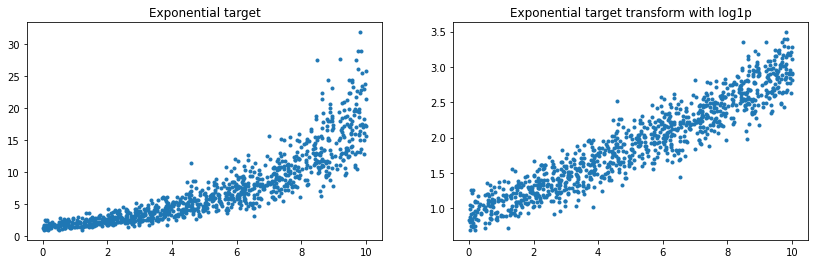

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(X[:, 0], y, '.')
ax[0].set_title('Exponential target')
ax[1].plot(X[:, 0], y_trans, '.')
ax[1].set_title('Exponential target transform with log1p');

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor

reg = LinearRegression()
reg.fit(X, y)

regr_trans = TransformedTargetRegressor(regressor=LinearRegression(),
                                        func=numpy.log1p,
                                        inverse_func=numpy.expm1)
regr_trans.fit(X, y)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=LinearRegression())

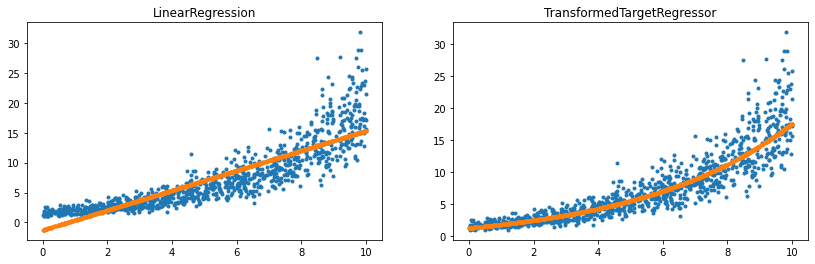

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(X[:, 0], y, '.')
ax[0].plot(X[:, 0], reg.predict(X), '.', label="Regular Linear Regression")
ax[0].set_title('LinearRegression')
ax[1].plot(X[:, 0], y, '.')
ax[1].plot(X[:, 0], regr_trans.predict(X), '.', label="Linear Regression with modified target")
ax[1].set_title('TransformedTargetRegressor');

## TransformedTargetRegressor2

Same thing with *mlinsights*.

In [8]:
from mlinsights.mlmodel import TransformedTargetRegressor2
regr_trans2 = TransformedTargetRegressor2(regressor=LinearRegression(),
                                         transformer='log1p')
regr_trans2.fit(X, y)

TransformedTargetRegressor2(regressor=LinearRegression(), transformer='log1p')

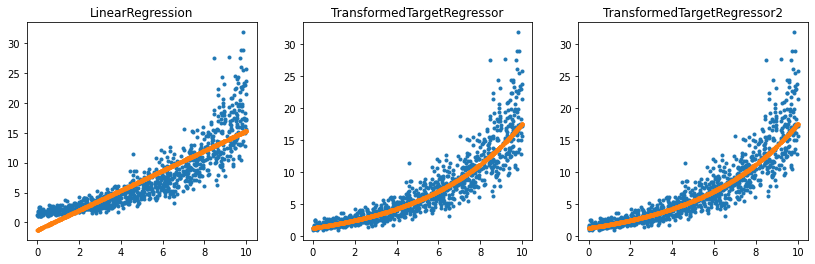

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
ax[0].plot(X[:, 0], y, '.')
ax[0].plot(X[:, 0], reg.predict(X), '.', label="Regular Linear Regression")
ax[0].set_title('LinearRegression')
ax[1].plot(X[:, 0], y, '.')
ax[1].plot(X[:, 0], regr_trans.predict(X), '.', label="Linear Regression with modified target")
ax[1].set_title('TransformedTargetRegressor')
ax[2].plot(X[:, 0], y, '.')
ax[2].plot(X[:, 0], regr_trans2.predict(X), '.', label="Linear Regression with modified target")
ax[2].set_title('TransformedTargetRegressor2');

It works the same way except the user does not have to specify the inverse function.

## Why another?

In [10]:
import pickle
by1 = pickle.dumps(regr_trans)
by2 = pickle.dumps(regr_trans2)

In [11]:
tr1 = pickle.loads(by1)
tr2 = pickle.loads(by2)

In [12]:
numpy.max(numpy.abs(tr1.predict(X) - tr2.predict(X)))

0.0

Well, to be honest, I did not expect numpy functions to be pickable. Lambda functions are not.

In [13]:
from pickle import PicklingError

regr_trans3 = TransformedTargetRegressor(regressor=LinearRegression(),
                                        func=lambda x: numpy.log1p(x),
                                        inverse_func=numpy.expm1)
regr_trans3.fit(X, y)

try:
    pickle.dumps(regr_trans3)
except PicklingError as e:
    print(e)

Can't pickle <function <lambda> at 0x00000195DBFD0C10>: attribute lookup <lambda> on __main__ failed


## Classifier and classes permutation

One question I get sometimes from my students is: regression or classification?

In [14]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
data = load_iris()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

In [15]:
from sklearn.linear_model import LinearRegression, LogisticRegression
reg = LinearRegression()
reg.fit(X_train, y_train)
log = LogisticRegression()
log.fit(X_train, y_train)

LogisticRegression()

In [16]:
from sklearn.metrics import r2_score
r2_score(y_test, reg.predict(X_test)), r2_score(y_test, log.predict(X_test))

(0.8752883470101486, 0.8325991189427313)

The accuracy does not work on the regression output as it produces float.

In [17]:
from sklearn.metrics import accuracy_score
try:
    accuracy_score(y_test, reg.predict(X_test)), accuracy_score(y_test, log.predict(X_test))
except ValueError as e:
    print(e)

Classification metrics can't handle a mix of multiclass and continuous targets


Based on that figure, a regression model would be better than a classification model on a problem which is known to be a classification problem. Let's play a little bit.

In [18]:
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils._testing import ignore_warnings

@ignore_warnings(category=(ConvergenceWarning, ))
def evaluation():
    rnd = []
    perf_reg = []
    perf_clr = []
    for rs in range(0, 200):
        rnd.append(rs)
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rs)
        reg = LinearRegression()
        reg.fit(X_train, y_train)
        log = LogisticRegression()
        log.fit(X_train, y_train)
        perf_reg.append(r2_score(y_test, reg.predict(X_test)))
        perf_clr.append(r2_score(y_test, log.predict(X_test)))
    return rnd, perf_reg, perf_clr

rnd, perf_reg, perf_clr = evaluation()

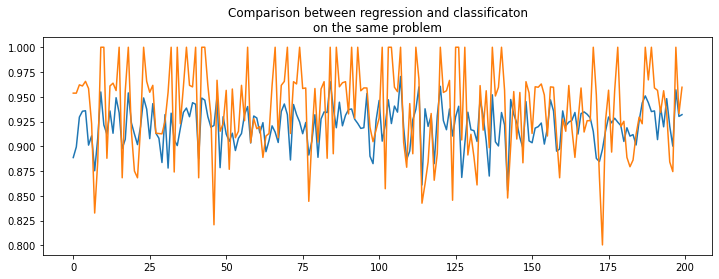

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(rnd, perf_reg, label="regression")
ax.plot(rnd, perf_clr, label="classification")
ax.set_title("Comparison between regression and classificaton\non the same problem");

Difficult to say. Knowing the expected value is an integer. Let's round the prediction made by the regression which is known to be integer.

In [20]:
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils._testing import ignore_warnings

def float2int(y):
    return numpy.int32(y + 0.5)

fct2float2int = numpy.vectorize(float2int)

@ignore_warnings(category=(ConvergenceWarning, ))
def evaluation2():
    rnd = []
    perf_reg = []
    perf_clr = []
    acc_reg = []
    acc_clr = []
    for rs in range(0, 50):
        rnd.append(rs)
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rs)
        reg = LinearRegression()
        reg.fit(X_train, y_train)
        log = LogisticRegression()
        log.fit(X_train, y_train)
        perf_reg.append(r2_score(y_test, float2int(reg.predict(X_test))))
        perf_clr.append(r2_score(y_test, log.predict(X_test)))
        acc_reg.append(accuracy_score(y_test, float2int(reg.predict(X_test))))
        acc_clr.append(accuracy_score(y_test, log.predict(X_test)))
    return (numpy.array(rnd), numpy.array(perf_reg), numpy.array(perf_clr),
            numpy.array(acc_reg), numpy.array(acc_clr))

rnd2, perf_reg2, perf_clr2, acc_reg2, acc_clr2 = evaluation2()

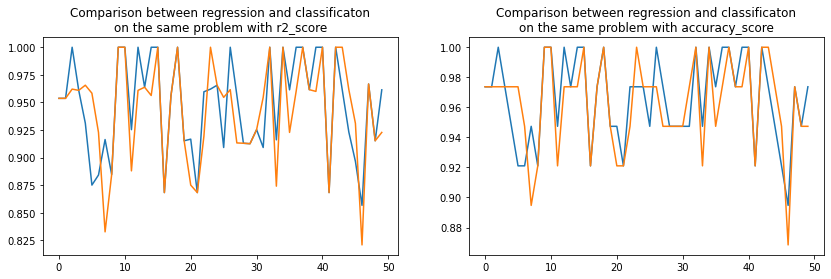

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(rnd2, perf_reg2, label="regression")
ax[0].plot(rnd2, perf_clr2, label="classification")
ax[0].set_title("Comparison between regression and classificaton\non the same problem with r2_score")
ax[1].plot(rnd2, acc_reg2, label="regression")
ax[1].plot(rnd2, acc_clr2, label="classification")
ax[1].set_title("Comparison between regression and classificaton\non the same problem with accuracy_score");

Pretty visually indecisive.

In [22]:
numpy.sign(perf_reg2 - perf_clr2).sum()

6.0

In [23]:
numpy.sign(acc_reg2 - acc_clr2).sum()

6.0

As strange as it seems to be, the regression wins on Iris data.

But... There is always a but...

## The but...

There is one tiny difference between regression and classification. Classification is immune to a permutation of the label.

In [24]:
data = load_iris()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12)

In [25]:
reg = LinearRegression()
reg.fit(X_train, y_train)
log = LogisticRegression()
log.fit(X_train, y_train)
(r2_score(y_test, fct2float2int(reg.predict(X_test))), 
 r2_score(y_test, log.predict(X_test)))

(1.0, 0.9609053497942387)

Let's permute between 1 and 2.

In [26]:
def permute(y):
    y2 = y.copy()
    y2[y == 1] = 2
    y2[y == 2] = 1
    return y2

y_train_permuted = permute(y_train)
y_test_permuted = permute(y_test)

regp = LinearRegression()
regp.fit(X_train, y_train_permuted)
logp = LogisticRegression()
logp.fit(X_train, y_train_permuted)
(r2_score(y_test_permuted, fct2float2int(regp.predict(X_test))), 
 r2_score(y_test_permuted, logp.predict(X_test)))

(0.43952802359882015, 0.9626352015732547)

The classifer produces almost the same performance, the regressor seems off. Let's check that it is just luck.

In [27]:
from mlinsights.mlmodel import TransformedTargetClassifier2
from pandas import DataFrame

rows = []
for i in range(0, 10):
    regpt = TransformedTargetRegressor2(LinearRegression(), transformer='permute')
    regpt.fit(X_train, y_train)
    logpt = TransformedTargetClassifier2(LogisticRegression(max_iter=200), transformer='permute')
    logpt.fit(X_train, y_train)
    rows.append({
        'reg_perm': regpt.transformer_.permutation_,
        'reg_score': r2_score(y_test, fct2float2int(regpt.predict(X_test))),
        'log_perm': logpt.transformer_.permutation_,
        'log_score': r2_score(y_test, logpt.predict(X_test))
    })

df = DataFrame(rows)
df

,reg_perm,reg_score,log_perm,log_score
0,"{0: 2, 1: 0, 2: 1}",0.061728,"{0: 1, 1: 2, 2: 0}",0.960905
1,"{0: 1, 1: 2, 2: 0}",-0.759259,"{0: 0, 1: 2, 2: 1}",0.960905
2,"{0: 2, 1: 1, 2: 0}",1.000000,"{0: 0, 1: 1, 2: 2}",0.960905
3,"{0: 0, 1: 2, 2: 1}",0.061728,"{0: 1, 1: 2, 2: 0}",0.960905
4,"{0: 1, 1: 0, 2: 2}",-0.759259,"{0: 1, 1: 2, 2: 0}",0.960905
5,"{0: 1, 1: 2, 2: 0}",-0.759259,"{0: 2, 1: 1, 2: 0}",0.960905
6,"{0: 2, 1: 0, 2: 1}",0.061728,"{0: 1, 1: 2, 2: 0}",0.960905
7,"{0: 0, 1: 1, 2: 2}",1.000000,"{0: 2, 1: 1, 2: 0}",0.960905
8,"{0: 2, 1: 0, 2: 1}",0.061728,"{0: 1, 1: 0, 2: 2}",0.960905
9,"{0: 1, 1: 2, 2: 0}",-0.759259,"{0: 1, 1: 0, 2: 2}",0.960905


The classifier produces a constant performance, the regressor is not.